In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json

from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import time
from datetime import datetime
import os
from torch.utils import data
import random
import copy
import itertools
import io
import uuid
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import umap
import hdbscan
import warnings
warnings.filterwarnings('ignore')

#import wandb
#wandb_username = 'denizjafari'
local_username = 'denizjafari'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0') 
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [3]:
# root directory
root_dir = "/home/andreasabo/Documents/HNProject/"
split_file_base = "/home/denizjafari/Documents/HNProject/HNUltra/"

# data directory on current machine: abhishekmoturu, andreasabo, denizjafari, navidkorhani
data_dir = "/home/" + local_username + "/Documents/HNProject/all_label_img/"

# read target df
csv_path = os.path.join(root_dir, "all_splits_1000000.csv")
data_df = pd.read_csv(csv_path, usecols=['subj_id', 'image_ids', 'view_label', 'view_train'])

In [4]:
data_df.head()

,image_ids,view_label,subj_id,view_train
0,1323_2_1,Missing,1323,NaN
1,1323_2_2,Missing,1323,NaN
2,1323_2_3,Missing,1323,NaN
3,1323_2_4,Missing,1323,NaN
4,1323_2_5,Missing,1323,NaN


### **Reading Data Indicies and Labels**

In [5]:
label_mapping = {'Other':0, 'Saggital_Right':1, 'Transverse_Right':2, 
                 'Saggital_Left':3, 'Transverse_Left':4, 'Bladder':5}
label_unmapping = {0: 'Other', 1:'Saggital_Right', 2: 'Transverse_Right', 
                   3:'Saggital_Left', 4:'Transverse_Left', 5: 'Bladder'}

data_df['view_label'] = data_df['view_label'].map(label_mapping)

train_df = data_df[data_df.view_train == 1]
test_df = data_df[data_df.view_train == 0]

unique_subj = train_df.subj_id.unique()

# Create the splits for 5-fold cross validation based on subj_id
data_split_file = split_file_base + 'data_splits.json'
if not os.path.isfile(data_split_file):

    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    fold = 0
    all_folds = {}
    for train_subj, val_subj in kf.split(unique_subj):
        train_ids  = unique_subj[train_subj]
        val_ids = unique_subj[val_subj]

        train_images = train_df[train_df.subj_id.isin(train_ids)].image_ids.tolist()
        val_images = train_df[train_df.subj_id.isin(val_ids)].image_ids.tolist()
        train_labels = train_df[train_df.subj_id.isin(train_ids)].view_label.tolist()
        val_labels = train_df[train_df.subj_id.isin(val_ids)].view_label.tolist()
        cur_fold = {'train_ids': train_images, 'valid_ids': val_images, 'train_labels': train_labels, 'valid_labels': val_labels}
        all_folds[fold] = cur_fold
        fold += 1

    print("Saving data splits")
    with open(data_split_file, 'w') as f:
        json.dump(all_folds, f)

else: # just load from file
    print("Reading splits from file")
    with open(data_split_file, 'r') as f:
        all_folds = json.load(f)
        

# just use one folds for now 
partition = all_folds['0']

train_ids = train_df['image_ids'].tolist()
train_labels = train_df['view_label'].tolist()
test_ids = test_df['image_ids'].tolist()
test_labels = test_df['view_label'].tolist()
#
partition_train = {'train_ids':train_ids, 'train_lables':train_labels}
partition_test = {'test_ids':test_ids, 'test_lables':test_labels}
#test_ids
#test_df.head()

Reading splits from file


In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    ct = 0 
    if feature_extracting:
        for child in model.children():
            ct +=1
            if ct <8:
                for param in child.parameters():
                    param.requires_grad = False

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.conv1 =  nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc = nn.Sequential( nn.Linear(num_ftrs, 60), nn.Linear(60, num_classes) ) 
        input_size = 256

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == 'viewnet':
        conv1_filters = 8
        conv2_filters = 16
        conv3_filters = 32
        linear1_size = 512
        dropout = 0.25
        model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
        input_size = 256
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, writer = None):
    since = time.time()
    classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 54)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            running_preds = []
            running_labels = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.long)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        labels = torch.argmax(labels, 1)
                        running_preds += torch.argmax(outputs, 1).tolist()
                        running_labels += labels.tolist()
                        loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} loss:\t{:.4f} | {} acc:\t{:.4f}\n'.format(phase, epoch_loss, phase, epoch_acc))
            # Log to tensorboard for visualization
            if writer is not None and phase == 'train':
                writer.add_scalar('Loss/train', epoch_loss, epoch)
                writer.add_scalar('Accuracy/train', epoch_acc, epoch)
#                 cm = confusion_matrix(running_labels, running_preds)
#                 figure = plot_confusion_matrix_local(cm, classnames)
#                 writer.add_image('confusion_matrix/train', figure, epoch)
                
                
                
            if writer is not None and phase == 'val':
                writer.add_scalar('Loss/val', epoch_loss, epoch)
                writer.add_scalar('Accuracy/val', epoch_acc, epoch)
                
#                 cm = confusion_matrix(running_labels, running_preds)
#                 figure = plot_confusion_matrix_local(cm, classnames)
#                 writer.add_image('confusion_matrix/val', figure, epoch)
            # deep copy the model
            if phase == 'train':
                print(classification_report(running_labels, running_preds))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(classification_report(running_labels, running_preds))
            if phase == 'val':
                val_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

DATA Loading

In [9]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, viewnet]
model_name = "resnet"

# Number of classes in the dataset: right_sag, right_trav, left_sag, left_trav, bladder, other
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 100

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model; when True we only update the reshaped layer params
feature_extract = True

# Flag for whether or not to use pretrained model
pretrain = True

In [10]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=feature_extract, use_pretrained=True)
#print(model_ft)

running the model

In [11]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4, weight_decay=0, amsgrad=True) # lr=1e-4, weight_decay=0, amsgrad=False

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 conv1.weight
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.0.weight
	 fc.0.bias
	 fc.1.weight
	 fc.1.bias


In [12]:
# Data augmentation and normalization for training
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img_path = data_dir + ID + '.jpg'
        image = Image.open(img_path).convert('L')
        image = ToTensor()(image)
        y = torch.FloatTensor([0]*6)
       
        y[int(self.labels[index])] = 1

        return image, y
# Parameters
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}

# Generators
training_set = Dataset(partition['train_ids'], partition['train_labels'])
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['valid_ids'], partition['valid_labels'])
validation_generator = data.DataLoader(validation_set, **params)

dataloaders_dict = {'train':training_generator, 'val':validation_generator}

In [13]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, 25, is_inception=(model_name=="inception"))

Epoch 1/25
------------------------------------------------------
train loss:	1.1504 | train acc:	0.5656

              precision    recall  f1-score   support

           0       0.56      0.78      0.65      3724
           1       0.60      0.43      0.50      1813
           2       0.58      0.24      0.34      1218
           3       0.49      0.53      0.51      1895
           4       0.49      0.35      0.41      1359
           5       0.76      0.74      0.75      1072

    accuracy                           0.57     11081
   macro avg       0.58      0.51      0.53     11081
weighted avg       0.57      0.57      0.55     11081

val loss:	1.1882 | val acc:	0.5412

              precision    recall  f1-score   support

           0       0.63      0.56      0.59      1219
           1       0.54      0.60      0.57       412
           2       0.52      0.44      0.47       321
           3       0.42      0.47      0.45       389
           4       0.34      0.43      0.38 

train loss:	0.0062 | train acc:	0.9978

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3724
           1       1.00      1.00      1.00      1813
           2       1.00      1.00      1.00      1218
           3       1.00      1.00      1.00      1895
           4       1.00      1.00      1.00      1359
           5       1.00      1.00      1.00      1072

    accuracy                           1.00     11081
   macro avg       1.00      1.00      1.00     11081
weighted avg       1.00      1.00      1.00     11081

val loss:	2.0783 | val acc:	0.5238

Epoch 12/25
------------------------------------------------------
train loss:	0.0051 | train acc:	0.9981

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3724
           1       1.00      1.00      1.00      1813
           2       1.00      1.00      1.00      1218
           3       1.00      1.00      1.00      1895
   

train loss:	0.0032 | train acc:	0.9984

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3724
           1       1.00      1.00      1.00      1813
           2       1.00      1.00      1.00      1218
           3       1.00      1.00      1.00      1895
           4       1.00      1.00      1.00      1359
           5       1.00      1.00      1.00      1072

    accuracy                           1.00     11081
   macro avg       1.00      1.00      1.00     11081
weighted avg       1.00      1.00      1.00     11081

val loss:	2.2088 | val acc:	0.5388

Epoch 24/25
------------------------------------------------------
train loss:	0.0029 | train acc:	0.9986

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3724
           1       1.00      1.00      1.00      1813
           2       1.00      1.00      1.00      1218
           3       1.00      1.00      1.00      1895
   

Now that the model is fine-tuned, we create a new dataset of train and test for feature extraction and clustering purposes 

In [14]:
from sklearn.cluster import KMeans
    
class I(nn.Module):
    def __init__(self):
        super(I, self).__init__()
    def forward(self, x):
        return x

model = model_ft
model = model.to(device)
print(model.fc)
model.fc[1] = I()




Sequential(
  (0): Linear(in_features=512, out_features=60, bias=True)
  (1): Linear(in_features=60, out_features=6, bias=True)
)


In [15]:
# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 6}

# Generators of the train and test dataset for clustering purposes 
training_set = Dataset(partition_train['train_ids'], partition_train['train_lables'])
training_generator = data.DataLoader(training_set, **params)

test_set = Dataset(partition_test['test_ids'], partition_test['test_lables'])
test_generator = data.DataLoader(test_set, **params)

dataloaders = {'train':training_generator, 'test':test_generator}

In [16]:
classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
features_train = []
features_test = []
#label_predictions = []
for image, label in dataloaders['train']:
    features_train.append(np.squeeze(model(image.to(device)).tolist()))
    #label_predictions.append(torch.argmax(label, 1)[0].item())
    
for image, label in dataloaders['test']:
    features_test.append(np.squeeze(model(image.to(device)).tolist()))
    #labels__predictions.append(torch.argmax(label, 1)[0].item())
    

print(len(features_train))
print(len(features_test))
print(features_train[-1].shape)
print(features_test[-1].shape)


13958
5070
(60,)
(60,)


# CLUSTERING DATA


In [17]:
# DATA 

y_train = partition_train['train_lables']

y_test = partition_test['test_lables']

print(len(partition_train['train_lables']))
print(len(y_train))
print(y_train[0])

print(len(partition_test['test_lables']))
print(len(y_test))
print(y_test[0])


print(len(features_train))
print(features_train[0].shape)

print(len(features_test))
print(features_test[0].shape)

13958
13958
0.0
5070
5070
1.0
13958
(60,)
5070
(60,)


# K-Means on ResNet18 Features

In [18]:
# performance on train data
kmeans = KMeans(n_clusters=6, random_state=0).fit(features_train)
print(v_measure_score(y_train, kmeans.labels_))
print(adjusted_rand_score(y_train, kmeans.labels_),
    adjusted_mutual_info_score(y_train, kmeans.labels_))


0.00048705813284930313
-0.0005030066177584993 -4.35003786526996e-05


In [19]:
# performance on test data 

y_pred_res = kmeans.predict(features_test)
print(v_measure_score(y_pred_res, y_test))
print(adjusted_rand_score(y_pred_res, y_test),
    adjusted_mutual_info_score(y_pred_res, y_test))

#print(confusion_matrix(y_test, y_pred_res))
print(classification_report(y_test, y_pred_res))

0.0010681322253152184
-0.0006702906850239764 -0.00040737465050562333
              precision    recall  f1-score   support

         0.0       0.39      0.31      0.35      1990
         1.0       0.16      0.17      0.17       790
         2.0       0.12      0.14      0.13       608
         3.0       0.12      0.10      0.11       684
         4.0       0.10      0.11      0.10       527
         5.0       0.09      0.16      0.12       471

    accuracy                           0.21      5070
   macro avg       0.16      0.16      0.16      5070
weighted avg       0.23      0.21      0.21      5070



In [75]:
# KMENA visualized in 2D via UMAP 

# THE TRUE LABLES 
mapper_k = umap.UMAP(random_state=42).fit(features_train)
mapper_k_t = umap.UMAP(random_state=42).trasform(features_test)
plt.scatter(mapper_k.embedding_[:, 0], mapper_k.embedding_[:, 1], c=y_train, s=0.1, cmap='Spectral')
plt.title('Train dataset Clustering via Kmean Visualized in 2D via UMAP - True Lables');

AttributeError: 'UMAP' object has no attribute 'trasform'

In [74]:
y= KMeans(n_clusters=6, random_state=0).fit(mapper_k.embedding_)

print(adjusted_mutual_info_score(y_train,y ))

y= mapper_k.predict(features_test)

print(adjusted_mutual_info_score(y_test,y ))

AttributeError: 'UMAP' object has no attribute 'predict'

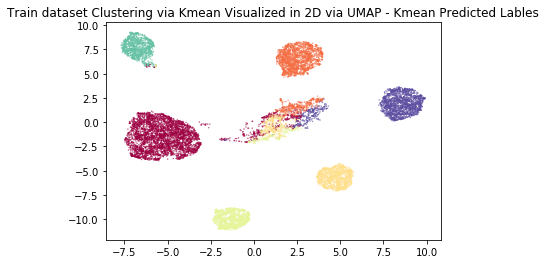

In [21]:
# the lables predicted by kmeans 
plt.scatter(mapper_k.embedding_[:, 0], mapper_k.embedding_[:, 1], c=kmeans.labels_, s=0.1, cmap='Spectral');
plt.title('Train dataset Clustering via Kmean Visualized in 2D via UMAP - Kmean Predicted Lables');

# UMAP CLUSTERING 

the difference between unsupervised and supervised method of UMAP clustering 

supervised clstering by fitting the data to the train y and then testing it on val data

In [22]:
mapper_res = umap.UMAP(n_neighbors=10,  metric = "manhattan",
                                  n_components=2,random_state=42).fit(features_train)


In [23]:
mapper_res2 = umap.UMAP(n_neighbors=50, min_dist=0.0, metric = "manhattan",
                                  n_components=2,random_state=42).fit(features_train, y=y_train)

In [24]:
val_embedding_1 = mapper_res.transform(features_test)
val_embedding = mapper_res2.transform(features_test)

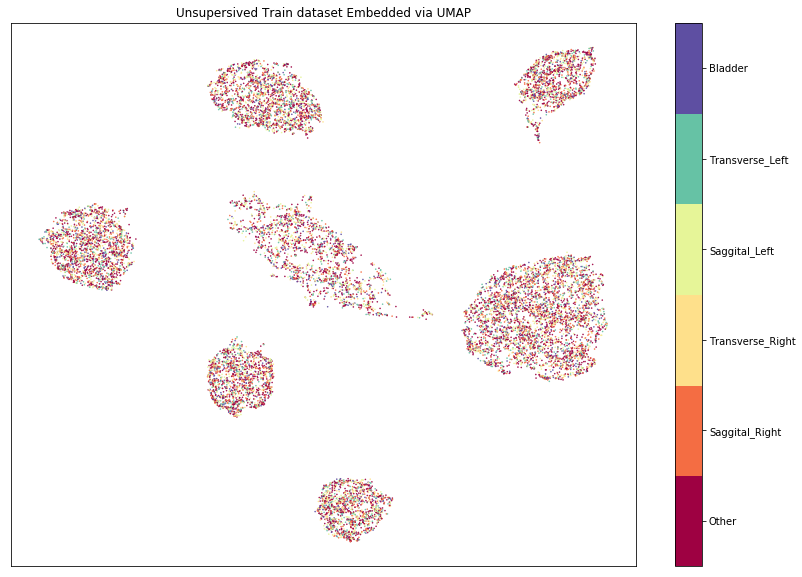

In [25]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper_res.embedding_.T, s=0.3, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Unsupersived Train dataset Embedded via UMAP');

plt.savefig('Unsupersived_Train.png')

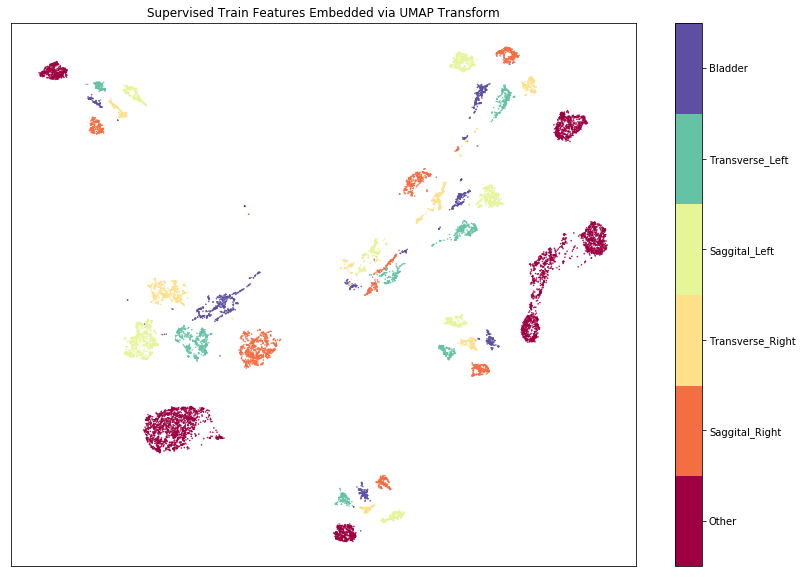

In [26]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper_res2.embedding_.T, s=0.3, c=np.array(y_train), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Supervised Train Features Embedded via UMAP Transform');
plt.savefig('supersived_Train.png')

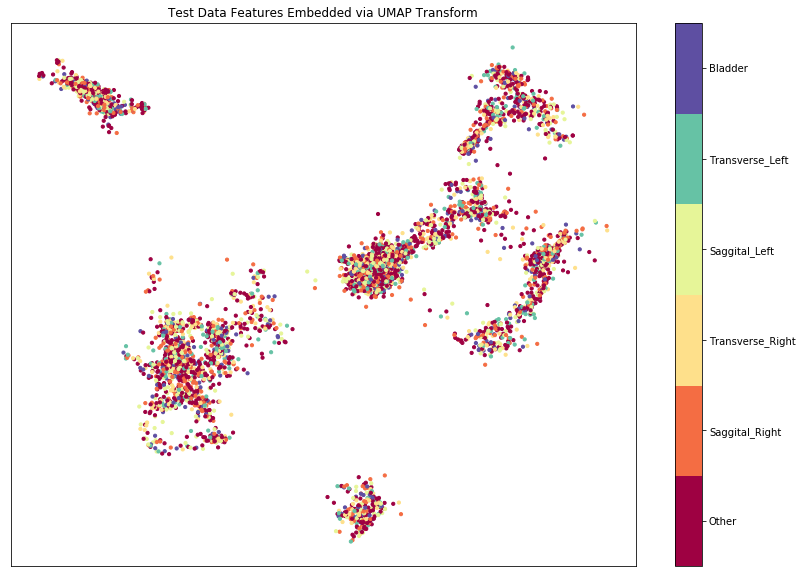

In [27]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*val_embedding.T, s=10, c=np.array(y_test), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Test Data Features Embedded via UMAP Transform');
plt.savefig('supersived_Test.png')

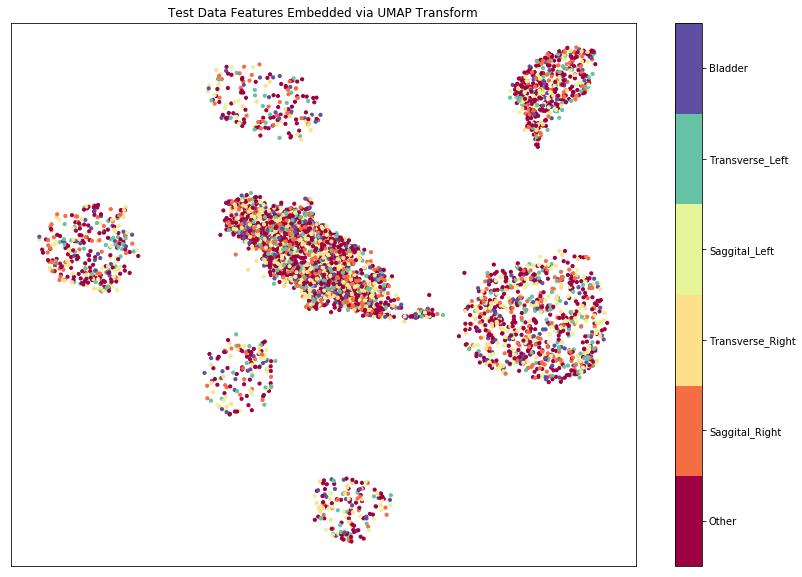

In [28]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*val_embedding_1.T, s=10, c=np.array(y_test), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Test Data Features Embedded via UMAP Transform');
plt.savefig('Unsupersived_Test.png')

# Seeing How KNN and SVN Behave 

In [29]:
svc = SVC().fit(features_train, y_train)
knn = KNeighborsClassifier().fit(features_train, y_train)

In [30]:
print(svc.score(features_test, y_test), knn.score(features_test, y_test))
y_pred_svc = knn.predict(features_test)
y_pred_knn = svc.predict(features_test)

print(adjusted_rand_score(y_test, y_pred_svc), adjusted_mutual_info_score(y_test, y_pred_svc))
print(v_measure_score(y_pred_svc, y_test))
print(classification_report(y_test, y_pred_svc))
print()
print(adjusted_rand_score(y_test, y_pred_knn), adjusted_mutual_info_score(y_test, y_pred_knn))
print(v_measure_score(y_pred_knn, y_test))
print(classification_report(y_test, y_pred_knn))


0.39250493096646943 0.2938856015779093
-0.005378497829281705 -0.00016461981472842754
0.0015819769164976069
              precision    recall  f1-score   support

         0.0       0.39      0.63      0.48      1990
         1.0       0.17      0.11      0.14       790
         2.0       0.12      0.06      0.08       608
         3.0       0.13      0.11      0.12       684
         4.0       0.10      0.05      0.06       527
         5.0       0.10      0.04      0.06       471

    accuracy                           0.29      5070
   macro avg       0.17      0.17      0.15      5070
weighted avg       0.23      0.29      0.25      5070


0.0 -1.1384186486908916e-15
-6.441343226343385e-16
              precision    recall  f1-score   support

         0.0       0.39      1.00      0.56      1990
         1.0       0.00      0.00      0.00       790
         2.0       0.00      0.00      0.00       608
         3.0       0.00      0.00      0.00       684
         4.0       0.00    

In [31]:
umap_helper = umap.UMAP(n_neighbors=50,  metric = "manhattan",
                                  n_components=6,random_state=42).fit(features_train)

In [32]:
#print(svc.score(umap_helper.transform(features_test), y_test),
#      knn.score(umap_helper.transform(features_test), y_test))


knn = KNeighborsClassifier().fit(umap_helper.embedding_, y_train)
y = knn.predict(umap_helper.embedding_)
print(adjusted_mutual_info_score(y_train, y))
y_pred_knn = umap_helper.transform(features_test)
print(y_pred_knn.shape)
y_pred_knn = knn.predict(y_pred_knn)
print(adjusted_mutual_info_score(y_test, y_pred_knn))
#print(v_measure_score(y_pred_knn, y_test))
#print(classification_report(y_test, y_pred_knn))
#print(v_measure_score(y_val, kmeans_200.labels_))

0.09851805638727291
(5070, 6)
0.0009137659839659764


# TSNE 

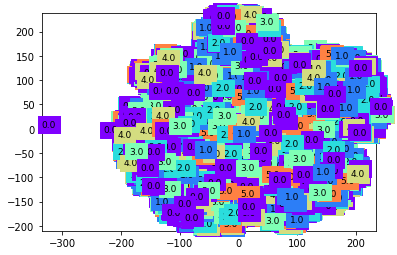

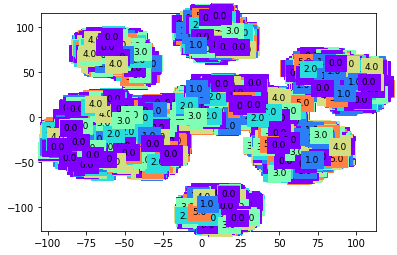

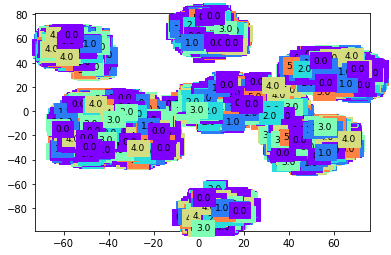

In [33]:
# Plot tsne clustering based on fine-tuned resnet18 outputs, with labels of correct answer
from matplotlib import cm
from sklearn.manifold import TSNE

def plot_with_labels(lowDWeights, labels):
    #plt.cla() # Clear current axis
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 6)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()) 
    plt.ylim(Y.min(), Y.max())
    plt.show()

    
preplexity = [5, 50, 100]

for p in preplexity:
    tsne = TSNE(perplexity=p, n_components=2, init='pca', n_iter=5000)
    low_dim_embs = tsne.fit_transform(features_train)
    plot_with_labels(low_dim_embs, y_train)


In [39]:
features_train[0]

array([ 3.10920429e+00,  3.51663768e-01,  8.79308581e-01, -1.96250665e+00,
        9.75087360e-02,  3.35422254e+00, -2.57227850e+00,  1.74309742e+00,
       -1.00821662e+00,  2.47758698e+00,  2.27254495e-01,  8.89122427e-01,
       -3.50355208e-01, -1.98305309e+00, -9.40255105e-01,  1.17596078e+00,
        1.66466177e+00, -1.14534743e-01, -1.54445612e+00,  1.70322073e+00,
       -5.62767386e-01,  5.04008159e-02,  7.57929206e-01,  8.19613218e-01,
        3.01251483e+00,  1.70166588e+00, -5.37114859e-01, -7.80045092e-02,
       -9.26678002e-01,  7.68993020e-01,  1.82359624e+00, -3.21833462e-01,
        4.06410784e-01,  2.09177876e+00, -5.52139223e-01,  4.90917236e-01,
       -5.25209546e-01, -2.25476921e-03,  2.62781501e-01, -3.77614021e-01,
       -1.14261711e+00, -1.73704338e+00,  6.17400169e-01, -2.09784746e+00,
       -9.18892026e-01, -9.42429066e-01,  2.97619867e+00,  1.94526231e+00,
       -3.96326035e-01,  9.34224188e-01,  2.56484509e+00, -1.71840155e+00,
        7.49749362e-01, -

# HDBSCAN on ResNet Features

In [42]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(features_train)

print(clusterer.labels_.max())
print(clusterer.labels_.min())
clustered = (clusterer.labels_ >= 0)
print(adjusted_mutual_info_score(np.array(y_train)[clustered], clusterer.labels_[clustered]))

test_labels, strengths = hdbscan.approximate_predict(clusterer, features_test)

clustered_t = (test_labels >= 0)
print(adjusted_mutual_info_score(np.array(y_test)[clustered_t], clustered_t[clustered_t]))
clusterer.labels_

20
-1
0.00033939391990705776


AttributeError: No prediction data was generated

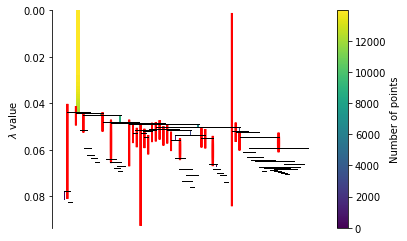

In [40]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [ ]:
classnames_2 = ['noise','Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder', 'unknown']

fig, ax = plt.subplots(1, figsize=(14, 10))
color_palette = sns.color_palette('deep', 20)
cluster_colors = [color_palette[x] if x >= 0
              else (0.5, 0.5, 0.5)
              for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                     zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(mapper_res.embedding_[:, 0], mapper_res.embedding_[:, 1], s=20, linewidth=0, c=cluster_member_colors, alpha=0.25, cmap='Spectral')


In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(mapper_res.embedding_[:, 0], mapper_res.embedding_[:, 1], c=y_train, s=30, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP');

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
clustered = (clusterer.labels_ >= 0)
plt.scatter(mapper_res.embedding_[~clustered, 0],
            mapper_res.embedding_[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=2,
            alpha=0.5)

plt.scatter(mapper_res.embedding_[clustered, 0],
            mapper_res.embedding_[clustered, 1],
            c=clusterer.labels_[clustered],
            s=2,
            cmap='Spectral');
cbar = plt.colorbar(boundaries=np.arange(9)-0.5)
cbar.set_ticks(np.arange(8))
cbar.set_ticklabels(classnames_2)

In [ ]:
print(v_measure_score(y_train, clusterer.labels_))
print(adjusted_rand_score(np.array(y_train)[clustered], clusterer.labels_[clustered]),
      adjusted_mutual_info_score(np.array(y_train)[clustered], clusterer.labels_[clustered]))
print(confusion_matrix(y_train, clusterer.labels_))
print(classification_report(y_train,clusterer.labels_))

# NUmber of datapoints used 
np.sum(clustered) / len(y_train)

# TRYING CLUSTERING METHODS ON RESNET FEATURES 

In [43]:
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

def plot_clusters(data,y, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    #print(v_measure_score(y, labels))
    #print(confusion_matrix(y, labels))
    #print(classification_report(y,labels))
    print(adjusted_mutual_info_score(y_train, kmeans.labels_))
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
   # plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)


def test_clusters(train,y_train,test,y_test, algorithm, args, kwds):
    start_time = time.time()
    #fitted = algorithm(*args, **kwds).fit(train)
    labels = algorithm(*args, **kwds).fit_predict(train)
    #print(v_measure_score(y, labels))
    #print(confusion_matrix(y, labels))
    #print(classification_report(y,labels))
    print(adjusted_mutual_info_score(y_train, labels))
    labels = algorithm(*args, **kwds).fit_predict(test)
    print(adjusted_mutual_info_score(y_test, labels))
    
    
def t_clusters(train,y_train,test,y_test, algorithm, args, kwds):
    start_time = time.time()
    fitted = algorithm(*args, **kwds).fit(train)
    labels = fitted.predict(train)
    #print(v_measure_score(y, labels))
    #print(confusion_matrix(y, labels))
    #print(classification_report(y,labels))
    print(adjusted_mutual_info_score(y_train, labels))
    labels = fitted.predict(test)
    print(adjusted_mutual_info_score(y_test, labels))
   

In [44]:
t_clusters(features_train, y_train,features_test, y_test, cluster.KMeans, (), {'n_clusters':6})


-4.51219027276084e-05
-0.000407374650504453


In [45]:
t_clusters(mapper_res.embedding_, y_train, val_embedding_1,y_test, cluster.KMeans, (), {'n_clusters':6})


3.2120511334355475e-06
-0.0006902676043021209


In [ ]:
#plot_clusters(mapper_res.embedding_,y_train, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})


In [ ]:
#plot_clusters(mapper_res.embedding_,y_train, cluster.MeanShift, (0.175,), {'cluster_all':False})


In [ ]:
#plot_clusters(mapper_res.embedding_,y_train, cluster.SpectralClustering, (), {'n_clusters':6})


In [47]:
plot_clusters(features_train, y_train, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})


-4.35003786526996e-05


AttributeError: 'list' object has no attribute 'T'

In [48]:
plot_clusters(features_train, y_train, cluster.DBSCAN, (), {'eps':0.025})


-4.35003786526996e-05


AttributeError: 'list' object has no attribute 'T'

In [ ]:
test_clusters(features_train, y_train,features_test, y_test, hdbscan.HDBSCAN, (), {'min_cluster_size':5})


test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)

# VAE (Navid's encoder)


In [49]:
class VAE_50(nn.Module):
    def __init__(self):
        super(VAE_50, self).__init__()
        
        hidden_dim = 800
        latent_dim = 50
        self.fc1 = nn.Linear(65536, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 65536)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print("z.size() =", z.size())
        h3 = F.relu(self.fc3(z))
        #print("h3.size() =", h3.size())
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 65536))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    
class VAE_100(nn.Module):
    def __init__(self):
        super(VAE_100, self).__init__()
        
        hidden_dim = 800
        latent_dim = 100
        self.fc1 = nn.Linear(65536, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 65536)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print("z.size() =", z.size())
        h3 = F.relu(self.fc3(z))
        #print("h3.size() =", h3.size())
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 65536))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
class VAE_200(nn.Module):
    def __init__(self):
        super(VAE_200, self).__init__()
        
        hidden_dim = 800
        latent_dim = 200
        self.fc1 = nn.Linear(65536, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 65536)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print("z.size() =", z.size())
        h3 = F.relu(self.fc3(z))
        #print("h3.size() =", h3.size())
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 65536))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [50]:
vae50_dir = '/home/navidkorhani/Documents/HNProject/HNUltra/saved models/vae_model_h800_l50.pt'
vae100_dir = "/home/navidkorhani/Documents/HNProject/HNUltra/results/h800_l100_e30/vae_model.pt"
vae200_dir = "/home/navidkorhani/Documents/HNProject/HNUltra/results/h800_l200_e30/vae_model.pt"

model_50 = VAE_50()
checkpoint = torch.load(vae50_dir)
model_50.load_state_dict(checkpoint)

model_100 = VAE_100()
checkpoint = torch.load(vae100_dir)
model_100.load_state_dict(checkpoint)

model_200 = VAE_200()
checkpoint = torch.load(vae200_dir)
model_200.load_state_dict(checkpoint)

<All keys matched successfully>

In [52]:
# change this such that I can read the labels as well 

z_all_50 = []
z_all_100 = []
z_all_200 = []
#z_labels = []
for  image, label in training_set:
    #z_labels.append(label)
    mu, logvar = model_50.encode(image.view(-1, 65536))
    z = model_50.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_50.append(z)
    mu, logvar = model_100.encode(image.view(-1, 65536))
    z = model_100.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_100.append(z)
    mu, logvar = model_200.encode(image.view(-1, 65536))
    z = model_200.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_200.append(z)


In [53]:
z_all_50_v = []
z_all_100_v = []
z_all_200_v = []
for  image, label in test_set:
    #z_labels.append(label)
    mu, logvar = model_50.encode(image.view(-1, 65536))
    z = model_50.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_50_v.append(z)
    mu, logvar = model_100.encode(image.view(-1, 65536))
    z = model_100.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_100_v.append(z)
    mu, logvar = model_200.encode(image.view(-1, 65536))
    z = model_200.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_200_v.append(z)


In [54]:
print(len(z_all_50))
print(len(z_all_100))
print(len(z_all_200))
print(len(y_train))
print(len(z_all_50_v))
print(len(z_all_100_v))
print(len(y_test))

13958
13958
13958
13958
5070
5070
5070


In [55]:
z_all_50 = [z.reshape(-1,) for z in z_all_50]
z_all_100 = [z.reshape(-1,) for z in z_all_100]
z_all_200 = [z.reshape(-1,) for z in z_all_200]

z_all_50_v = [z.reshape(-1,) for z in z_all_50_v]
z_all_100_v = [z.reshape(-1,) for z in z_all_100_v]
z_all_200_v = [z.reshape(-1,) for z in z_all_200_v]

In [56]:
print(z_all_50[0].shape)
print(z_all_50_v[0].shape)


(50,)
(50,)


In [57]:
# KNN and SVC on VAE


#svc_50 = SVC().fit(z_all_50, y_train)
knn_50 = KNeighborsClassifier().fit(z_all_50, y_train)
z_pred_knn = knn_50.predict(z_all_50)
print(adjusted_rand_score(y_train, z_pred_knn), adjusted_mutual_info_score(y_train, z_pred_knn))
#z_pred_svc = svc_50.predict(z_all_50_v)
z_pred_knn = knn_50.predict(z_all_50_v)

#print(svc_50.score(z_pred_svc, y_test), knn_50.score(z_pred_knn, y_test))
#print(classification_report(y_test, z_pred_knn))
print(adjusted_rand_score(y_test, z_pred_knn), adjusted_mutual_info_score(y_test, z_pred_knn))
#print(v_measure_score(z_pred_knn, y_test))
print()

#svc_50 = SVC().fit(z_all_100, y_train)
knn_50 = KNeighborsClassifier().fit(z_all_100, y_train)
z_pred_knn = knn_50.predict(z_all_100)
print(adjusted_rand_score(y_train, z_pred_knn), adjusted_mutual_info_score(y_train, z_pred_knn))
#z_pred_svc = knn_50.predict(z_all_100_v)
z_pred_knn = knn_50.predict(z_all_100_v)

#print(svc_50.score(z_pred_svc, y_test), knn_50.score(z_pred_knn, y_test))
#print(classification_report(y_test, z_pred_knn))
print(adjusted_rand_score(y_test, z_pred_knn), adjusted_mutual_info_score(y_test, z_pred_knn))
#print(v_measure_score(z_pred_knn, y_test))
print()

#svc_50 = SVC().fit(z_all_200, y_train)
knn_50 = KNeighborsClassifier().fit(z_all_200, y_train)
z_pred_knn = knn_50.predict(z_all_200)
print(adjusted_rand_score(y_train, z_pred_knn), adjusted_mutual_info_score(y_train, z_pred_knn))
#z_pred_svc = svc_50.predict(z_all_200_v)
z_pred_knn = knn_50.predict(z_all_200_v)

#print(svc_50.score(z_pred_svc, y_test), knn_50.score(z_pred_knn, y_test))
#print(classification_report(y_test, z_pred_knn))
print(adjusted_rand_score(y_test, z_pred_knn), adjusted_mutual_info_score(y_test, z_pred_knn))
#print(v_measure_score(z_pred_knn, y_test))
print()



0.3842337629660938 0.4164275387587111
0.11149362776443257 0.10965040788937197

0.31908488482212893 0.3667243336097319
0.08517666568657059 0.0803941623959479

0.27675033230079593 0.33814497657478715
0.06428857015181409 0.05789745728455577



In [58]:
# KMEANS on VAE

# training
kmeans_50 = KMeans(n_clusters=6, random_state=0).fit(z_all_50)
kmeans_100 = KMeans(n_clusters=6, random_state=0).fit(z_all_100)
kmeans_200 = KMeans(n_clusters=6, random_state=0).fit(z_all_200)
# kmeans_labels = KMeans(n_clusters=6).fit_predict(features_train)

#print(v_measure_score(y_train, kmeans_50.labels_))
print(adjusted_rand_score(y_train, kmeans_50.labels_), adjusted_mutual_info_score(y_train, kmeans_50.labels_))

#print(v_measure_score(y_train, kmeans_100.labels_))
print(adjusted_rand_score(y_train, kmeans_100.labels_), adjusted_mutual_info_score(y_train, kmeans_100.labels_))

#print(v_measure_score(y_train, kmeans_200.labels_))
print(adjusted_rand_score(y_train, kmeans_200.labels_), adjusted_mutual_info_score(y_train, kmeans_200.labels_))

0.0198837034895574 0.039373344869805496
0.02657801181588602 0.045555596619775825
0.029746584381918847 0.0464121584288924


In [59]:
# Test Set
l_50 = kmeans_50.predict(z_all_50_v)
print(adjusted_mutual_info_score(y_test, l_50))

l_100 = kmeans_100.predict(z_all_100_v)
print(adjusted_mutual_info_score(y_test, l_100))

l_200 = kmeans_200.predict(z_all_200_v)
print(adjusted_mutual_info_score(y_test, l_200))

0.03419229367933443
0.038974413055486934
0.042376911002779016


## TABLE FOR PRESENTATION

In [67]:
def z_clusters(train,y_train,test,y_test, algorithm, args, kwds):
    start_time = time.time()
    fitted = algorithm(*args, **kwds).fit(train)
    labels = fitted.predict(train)
    #print(v_measure_score(y, labels))
    #print(confusion_matrix(y, labels))
    #print(classification_report(y,labels))
    print(adjusted_mutual_info_score(y_train, labels))
    labels = fitted.predict(test)
    print(adjusted_mutual_info_score(y_test, labels))
    print('End')
    print()
        
    
def zTrain_clusters(train,y_train, algorithm, args, kwds):
    start_time = time.time()
    #fitted = algorithm(*args, **kwds).fit(train)
    labels = algorithm(*args, **kwds).fit_predict(train)
    #print(v_measure_score(y, labels))
    #print(confusion_matrix(y, labels))
    #print(classification_report(y,labels))
    print(adjusted_mutual_info_score(y_train, labels))
    #labels = algorithm(*args, **kwds).fit_predict(test)
    #print(adjusted_mutual_info_score(y_test, labels))
    
    

In [62]:
# KMEAN EMBEDDINGS 
mapper_z = umap.UMAP(n_neighbors=10,  metric = "manhattan",
                                  n_components=2,random_state=42).fit(z_all_50)
val_embedding_1 = mapper_res.transform(z_all_50_v)
z_clusters(mapper_res.embedding_, y_train, val_embedding_1,y_test, cluster.KMeans, (), {'n_clusters':6})

3.2120511334352265e-06
0.00046376343362589416
End



In [64]:

mapper_z = umap.UMAP(n_neighbors=10,  metric = "manhattan",
                                  n_components=2,random_state=42).fit(z_all_100)
val_embedding_1 = mapper_res.transform(z_all_100_v)
z_clusters(mapper_res.embedding_, y_train, val_embedding_1,y_test, cluster.KMeans, (), {'n_clusters':6})

3.212051133434457e-06
0.0026003648565382904
End



In [65]:

mapper_z = umap.UMAP(n_neighbors=10,  metric = "manhattan",
                                  n_components=2,random_state=42).fit(z_all_200)
val_embedding_1 = mapper_res.transform(z_all_200_v)
z_clusters(mapper_res.embedding_, y_train, val_embedding_1,y_test, cluster.KMeans, (), {'n_clusters':6})

3.212051133434777e-06
-7.580009723114157e-05
End



In [68]:
# Agglomerative 
zTrain_clusters(z_all_50,y_train, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})
zTrain_clusters(z_all_100,y_train, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})
zTrain_clusters(z_all_200,y_train, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

0.040444522064476164
0.05610039370245275
0.05819066637752522


In [69]:
# DBSCAN 
zTrain_clusters(z_all_50,y_train, cluster.DBSCAN, (), {'eps':0.025})
zTrain_clusters(z_all_100,y_train, cluster.DBSCAN, (), {'eps':0.025})
zTrain_clusters(z_all_200,y_train, cluster.DBSCAN, (), {'eps':0.025})

4.975777187986769e-17
4.975777187986769e-17
4.975777187986769e-17


In [71]:
# DBSCAN 
zTrain_clusters(z_all_50,y_train, hdbscan.HDBSCAN, (), {'min_cluster_size':5})
zTrain_clusters(z_all_100,y_train, hdbscan.HDBSCAN, (), {'min_cluster_size':5})
zTrain_clusters(z_all_200,y_train, hdbscan.HDBSCAN, (), {'min_cluster_size':5})

0.05219425760721753
0.03161867667113558
0.030399204898931255


In [73]:
clusterer = hdbscan.HDBSCAN(metric = "manhattan")
clusterer.fit(z_all_50)

print(clusterer.labels_.max())
print(clusterer.labels_.min())
clustered = (clusterer.labels_ >= 0)
print(adjusted_mutual_info_score(np.array(y_train)[clustered], clusterer.labels_[clustered]))

test_labels, strengths = hdbscan.approximate_predict(clusterer, z_all_50_v)

clustered_t = (test_labels >= 0)
print(adjusted_mutual_info_score(np.array(y_test)[clustered_t], clustered_t[clustered_t]))
clusterer.labels_

1
-1
0.0009869027586986807


AttributeError: No prediction data was generated

# UMAP VISUALIZATION FOR VAE 

In [ ]:
mapper_z = umap.UMAP(n_neighbors=10,  metric = "manhattan",
                                  n_components=2,random_state=42).fit(z_all_100)

val_embedding_1 = mapper_res.transform(z_all_100_v)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper_res.embedding_.T, s=0.3, c=np.array(y_train), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('VAE 100 Train Data Embedded via UMAP');

#plt.savefig('Unsupersived_Train.png')

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*val_embedding_1.T, s=10, c=np.array(y_test), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('VAE 100 Test Data Embedded via UMAP');
#plt.savefig('Unsupersived_Test.png')

In [ ]:
#z_clusters(z_all_100,y_train, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [ ]:
#z_clusters(z_all_100,y_train, cluster.MeanShift, (0.175,), {'cluster_all':False})


In [ ]:
#z_clusters(z_all_100,y_train, cluster.SpectralClustering, (), {'n_clusters':6})


In [ ]:
zTrain_clusters(z_all_100,y_train, cluster.DBSCAN, (), {'eps':0.025})


In [ ]:
z_clusters(z_all_100,y_train, hdbscan.HDBSCAN, (), {'min_cluster_size':5})

In [ ]:
# UMAP CLUSTERING FOR 50 FEATURES 


clusterable_embedding_50 = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit_transform(z_all_50)



fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(clusterable_embedding_50[:, 0], clusterable_embedding_50[:, 1], c=y_train, s=10, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP - VAE 50');


In [ ]:
# UMAP CLUSTERING FOR 100 FEATURES 

mapper_100 = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit(z_all_100)



fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(mapper_100.embedding_[:,0], mapper_100.embedding_[:,1],c=y_train, s=10, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP - VAE 100');

In [ ]:
clusterable_embedding_100.embedding_.shape

In [ ]:
#umap.plot.diagnostic(mapper_100, diagnostic_type='vq')

In [ ]:



val_embedding = mapper_100.transform(z_all_100_v)


fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(val_embedding[:, 0], val_embedding[:, 1], c=y_val, s=20, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Validation Encoded Features Embedded via UMAP - VAE 100');

In [ ]:

mapper_200 = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit(z_all_200)


fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(mapper_200.embedding_[:,0], mapper_200.embedding_[:,1], c=y_train, s=10, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP - VAE 200');

In [ ]:
clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit_transform(z_all_200)

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=y_train, s=10, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP');

In [ ]:
# 100 latent variables 

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=y_train, s=30, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP');

In [ ]:
# 100 latent variables 


fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(mapper_100.embedding_[:, 0], mapper_100.embedding_[:, 1], c=y_train, s=30, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP');

# HDBSCAN

In [ ]:
clusterer_z = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True, metric='manhattan')
clusterer_z.fit(z_all_100)
print(clusterer_z.labels_.max())

In [ ]:
clusterer_z_50 = hdbscan.HDBSCAN(metric='manhattan')
clusterer_z_50.fit(z_all_50)
print(clusterer_z_50.labels_.max())

In [ ]:
clusterer_z_50.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [ ]:
clusterer_z = hdbscan.HDBSCAN(min_cluster_size=5,prediction_data=True, metric='manhattan')
clusterer_z.fit(z_all_200)
print(clusterer_z.labels_.max())

In [ ]:
np.sum(clustered) / len(y_train)

In [ ]:
clusterer_z.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

# TRYING BUNCH of CLUSTERING ALGORITHMS on ResNet18 features

In [ ]:
labels

In [ ]:
plot_clusters(mapper_res.embedding_,y_train, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [ ]:
plot_clusters(mapper_res.embedding_,y_train, cluster.MeanShift, (0.175,), {'cluster_all':False})

In [ ]:
plot_clusters(mapper_res.embedding_,y_train, cluster.MeanShift, (0.175,), {'cluster_all':False})
plot_clusters(mapper_res.embedding_,y_train, cluster.SpectralClustering, (), {'n_clusters':6})
plot_clusters(mapper_res.embedding_,y_train, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})
plot_clusters(mapper_res.embedding_,y_train, cluster.DBSCAN, (), {'eps':0.025})
plot_clusters(mapper_res.embedding_,y_train, hdbscan.HDBSCAN, (), {'min_cluster_size':5})

In [ ]:
plot_clusters(mapper_res.embedding_,y_train, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

In [ ]:
plot_clusters(mapper_res.embedding_,y_train, cluster.DBSCAN, (), {'eps':0.025})

In [ ]:
plot_clusters(mapper_res.embedding_,y_train, hdbscan.HDBSCAN, (), {'min_cluster_size':5})

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))

color_palette = sns.color_palette('deep', 40)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer_z.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer_z.probabilities_)]
plt.scatter(*clusterable_embedding.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25)

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classnames_2)


In [ ]:
clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit_transform(features_train)

labels_hdbscan = hdbscan.HDBSCAN(
    min_samples=10, min_cluster_size=500).fit_predict(clusterable_embedding)


clustered = (labels_hdbscan >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=2,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels_hdbscan[clustered],
            s=2,
            cmap='Spectral');

In [ ]:
labels_hdbscan.max()

In [ ]:
print(v_measure_score(y_train, labels_hdbscan))
print(adjusted_rand_score(y_train, labels_hdbscan), adjusted_mutual_info_score(y_train, labels_hdbscan))

In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

X= features

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

clust.fit(X)
space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
optics_labels = clust.labels_[clust.ordering_]

plt.figure()

# OPTICS
colors = ['g.', 'r.', 'b.', 'olive','y.', 'c.']
for klass, color in zip(range(0, 6), colors):
    Xk = X[clust.labels_ == klass]
    ax.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax.set_title('Automatic Clustering\nOPTICS')
plt.show()


In [ ]:
optics_labels.max()

In [ ]:
print(len(clust.labels_))
print(X[0])